In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


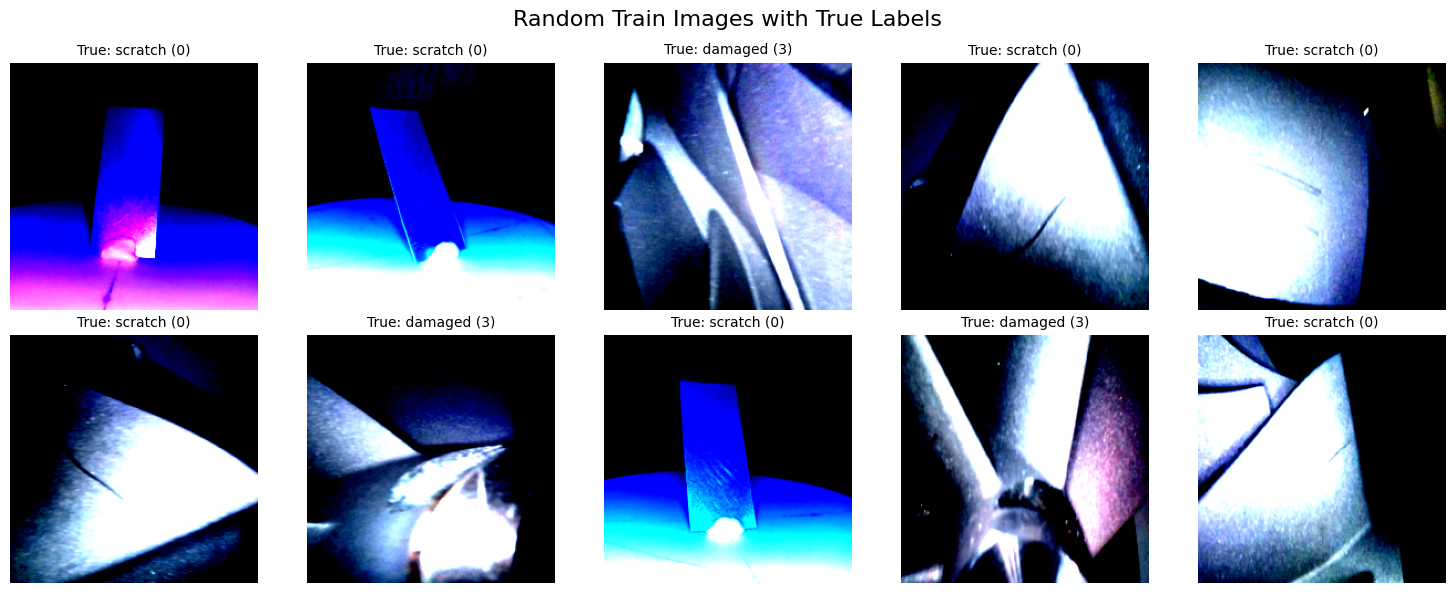

In [ ]:
from torchvision import transforms
from transformers import Trainer, TrainingArguments, ViTForImageClassification, TrainerCallback
import torch


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #this is to normalize pixel values and used imagenet dataset mean and variance
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataset = CustomImageDataset(image_dir=train_data_dir, label_dir=labels_train, transform=transform)


import matplotlib.pyplot as plt
import random
import numpy as np

#random train images
def plot_random_train_images(train_dataset, num_images=10):
    random_indices = random.sample(range(len(train_dataset)), num_images)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for idx, ax in zip(random_indices, axes):
        image, label = train_dataset[idx]["pixel_values"], train_dataset[idx]["labels"]
        image = image.permute(1, 2, 0).numpy() #to convert chw to hwc to make it compatible for visualization


        if image.dtype in ['float32', 'float64']:
            image = np.clip(image, 0, 1)
        elif image.dtype == 'int':
            image = np.clip(image, 0, 255)

        label_text = CLASS_MAPPING.get(label, f"{'scratch' if label == 0 else 'dirty' if label == 1 else 'stain' if label == 2 else 'damaged' if label == 3 else 'Unknown'} ({label})")

        ax.imshow(image)
        ax.set_title(f"True: {label_text}", fontsize=10)
        ax.axis("off")

    plt.suptitle("Random Train Images with True Labels", fontsize=16)
    plt.tight_layout()
    plt.show()


train_dataset = CustomImageDataset(image_dir=train_data_dir, label_dir=labels_train, transform=transform)
plot_random_train_images(train_dataset)


In [ ]:
import os

CLASS_MAPPING = {
    'scratch': 0,
    'dirty': 1,
    'stain': 2,
    'damage': 3
}

def load_labels(label_file_path):
    with open(label_file_path, 'r') as f:
        lines = f.readlines()


        for line in lines:

            values = line.strip().split()

            # this is to check if line is in correct format for label
            if len(values) < 5:
                raise ValueError(f"Invalid label format in file {label_file_path}")


            class_label_str = values[0]

            #convert label to int
            try:
                defect_type = int(class_label_str)
            except ValueError:
                raise ValueError(f"Expected numeric class label but found '{class_label_str}' in file {label_file_path}")
            try:
                bounding_box = list(map(float, values[1:]))
            except ValueError:
                raise ValueError(f"Could not be converted to floats in file {label_file_path}")

            return defect_type, bounding_box


from torch.utils.data import Dataset
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform
        self.label_data = self.load_all_labels()

    def load_all_labels(self):
        label_data = []
        for filename in os.listdir(self.label_dir):
            if filename.endswith(".txt") and filename != "classes.txt":
                label_path = os.path.join(self.label_dir, filename)
                try:
                    defect_type, bounding_box = load_labels(label_path)
                    label_data.append({
                        'filename': filename,
                        'defect_type': defect_type,
                        'bounding_box': bounding_box
                    })
                except ValueError as e:
                    print(f"Warning: {e}")
        return label_data

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)


        filename = self.image_files[idx].replace(".jpg", ".txt")
        labels = next((item for item in self.label_data if item["filename"] == filename), None)

        if labels:
            defect_type = labels["defect_type"]
        else:
            raise ValueError(f"Label not found for file: {filename}")

         # dictionary is returned so that it can be used with hugging face  trainer
        return {
            "pixel_values": image,
            "labels": defect_type
        }

def cleanup_label_directory(image_dir, label_dir):
    image_filenames = set(f.replace(".jpg", "") for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png')))

    for filename in os.listdir(label_dir):
        label_path = os.path.join(label_dir, filename)

        if not filename.endswith(".txt"):
            os.remove(label_path)
            print(f"Deleted non-text file: {filename}")
            continue

        if filename.replace(".txt", "") not in image_filenames:
            os.remove(label_path)
            print(f"Deleted label file with no corresponding image: {filename}")



train_data_dir = '/content/drive/MyDrive/Aero-engine_defect-detect_new/images/train'
val_data_dir = '/content/drive/MyDrive/Aero-engine_defect-detect_new/images/val'
labels_train = '/content/drive/MyDrive/Aero-engine_defect-detect_new/labels/train'
labels_val = '/content/drive/MyDrive/Aero-engine_defect-detect_new/labels/val'
eval_data_dir = '/content/drive/MyDrive/Aero-engine_defect-detect_new/images/eval'
labels_eval = '/content/drive/MyDrive/Aero-engine_defect-detect_new/labels/eval'

cleanup_label_directory(train_data_dir, labels_train)
cleanup_label_directory(val_data_dir, labels_val)
cleanup_label_directory(eval_data_dir, labels_eval)

In [ ]:
def cleanup_directories(image_dir, label_dir):


    image_filenames = set(f.replace(".jpg", "").replace(".jpeg", "").replace(".png", "")
                          for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png')))

    label_filenames = set(f.replace(".txt", "") for f in os.listdir(label_dir) if f.endswith(".txt"))


    for filename in os.listdir(image_dir):
        image_path = os.path.join(image_dir, filename)
        if not filename.endswith(('.jpg', '.jpeg', '.png')):
            continue

        image_base = filename.replace(".jpg", "").replace(".jpeg", "").replace(".png", "")
        if image_base not in label_filenames:
            os.remove(image_path)
            print(f"Deleted image file with no corresponding label: {filename}")


cleanup_directories(train_data_dir, labels_train)
cleanup_directories(val_data_dir, labels_val)
cleanup_directories(eval_data_dir, labels_eval)

In [ ]:
train_data_dir = '/content/drive/MyDrive/Aero-engine_defect-detect_new/images/train'
val_data_dir = '/content/drive/MyDrive/Aero-engine_defect-detect_new/images/val'
labels_train = '/content/drive/MyDrive/Aero-engine_defect-detect_new/labels/train'
labels_val = '/content/drive/MyDrive/Aero-engine_defect-detect_new/labels/val'
eval_data_dir = '/content/drive/MyDrive/Aero-engine_defect-detect_new/images/eval'
labels_eval = '/content/drive/MyDrive/Aero-engine_defect-detect_new/labels/eval'

In [ ]:
import os
import random
import shutil


#####      only run this code once


def split_train_val(train_image_dir, train_label_dir, eval_image_dir, eval_label_dir, split_ratio=0.2, seed=42):
    os.makedirs(eval_image_dir, exist_ok=True)
    os.makedirs(eval_label_dir, exist_ok=True)


    all_image_files = [f for f in os.listdir(train_image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]


    random.seed(seed)
    random.shuffle(all_image_files)

    split_index = int(len(all_image_files) * (1 - split_ratio))
    train_files = all_image_files[:split_index]
    eval_files = all_image_files[split_index:]


    for file in eval_files:

        src_image_path = os.path.join(train_image_dir, file)
        dest_image_path = os.path.join(eval_image_dir, file)
        shutil.move(src_image_path, dest_image_path)


        label_file = file.replace(".jpg", ".txt").replace(".jpeg", ".txt").replace(".png", ".txt")
        src_label_path = os.path.join(train_label_dir, label_file)
        dest_label_path = os.path.join(eval_label_dir, label_file)

        if os.path.exists(src_label_path):
            shutil.move(src_label_path, dest_label_path)
        else:
            print(f"Warning: Label file not found for image {file}")

    print(f"Dataset split completed.")
    print(f"Remaining training images: {len(train_files)}")
    print(f"Validation images moved: {len(eval_files)}")


In [ ]:
split_train_val(
    train_image_dir=train_data_dir,
    train_label_dir=labels_train,
    eval_image_dir=eval_data_dir,
    eval_label_dir=labels_eval,
    split_ratio=0.2
)

In [ ]:
import os
def count_files(image_dir, label_dir):

    image_count = len([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])

    label_count = len([f for f in os.listdir(label_dir) if f.endswith('.txt')])

    print(f"Number of images in '{image_dir}': {image_count}")
    print(f"Number of labels in '{label_dir}': {label_count}")

print("Training Data Counts:")
count_files(train_data_dir, labels_train)

print("\nValidation Data Counts:")
count_files(val_data_dir, labels_val)

print("\nEvaluation Data Counts:")
count_files(eval_data_dir, labels_eval)

Training Data Counts:
Number of images in '/content/drive/MyDrive/Aero-engine_defect-detect_new/images/train': 191
Number of labels in '/content/drive/MyDrive/Aero-engine_defect-detect_new/labels/train': 191

Validation Data Counts:
Number of images in '/content/drive/MyDrive/Aero-engine_defect-detect_new/images/val': 52
Number of labels in '/content/drive/MyDrive/Aero-engine_defect-detect_new/labels/val': 52

Evaluation Data Counts:
Number of images in '/content/drive/MyDrive/Aero-engine_defect-detect_new/images/eval': 48
Number of labels in '/content/drive/MyDrive/Aero-engine_defect-detect_new/labels/eval': 48


In [ ]:
# train_data_dir = '/content/drive/MyDrive/Aero-engine_defect-detect_new/images/train'
# val_data_dir = '/content/drive/MyDrive/Aero-engine_defect-detect_new/images/val'
# labels_train = '/content/drive/MyDrive/Aero-engine_defect-detect_new/labels/train'
# labels_val = '/content/drive/MyDrive/Aero-engine_defect-detect_new/labels/val'


In [ ]:
from torchvision import transforms
from transformers import Trainer, TrainingArguments, ViTForImageClassification, TrainerCallback
import torch

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataset = CustomImageDataset(image_dir=train_data_dir, label_dir=labels_train, transform=transform)
val_dataset = CustomImageDataset(image_dir=val_data_dir, label_dir=labels_val, transform=transform)


model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(CLASS_MAPPING)
)

training_args = TrainingArguments(
    output_dir='./results',
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)


class LossTrackingCallback(TrainerCallback):
    def __init__(self):
        self.training_losses = []
        self.validation_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        # this is to log loss at each step for both train and eval
        train_loss = logs.get("loss")
        if train_loss is not None:
            if state.epoch is not None and len(self.training_losses) < int(state.epoch):
                self.training_losses.append(train_loss)

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        val_loss = metrics.get("eval_loss")
        if val_loss is not None:
            self.validation_losses.append(val_loss)

    def save_losses(self, path='./losses.pt'):
        torch.save({'training_losses': self.training_losses, 'validation_losses': self.validation_losses}, path)

loss_callback = LossTrackingCallback()


#hugginface trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[loss_callback]
)


trainer.train()

trainer.save_model('./best_model')

torch.save(model.state_dict(), './best_model.pth')


loss_callback.save_losses('./losses.pt')


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_performance(model, image_dir, label_dir, transform, class_mapping, batch_size=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)


    test_dataset = CustomImageDataset(image_dir=image_dir, label_dir=label_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # store in form of list for y and y pred
    all_labels = []
    all_predictions = []


    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs.logits, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average="weighted")
    recall = recall_score(all_labels, all_predictions, average="weighted")

    class_names = [key.capitalize() for key in class_mapping.keys()]


    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")

    return all_labels, all_predictions


true_labels, predicted_labels = evaluate_model_performance(
    model,
    image_dir=eval_data_dir,
    label_dir=labels_eval,
    transform=transform,
    class_mapping=CLASS_MAPPING
)


Accuracy: 98.08%
Precision: 98.18%
Recall: 98.08%


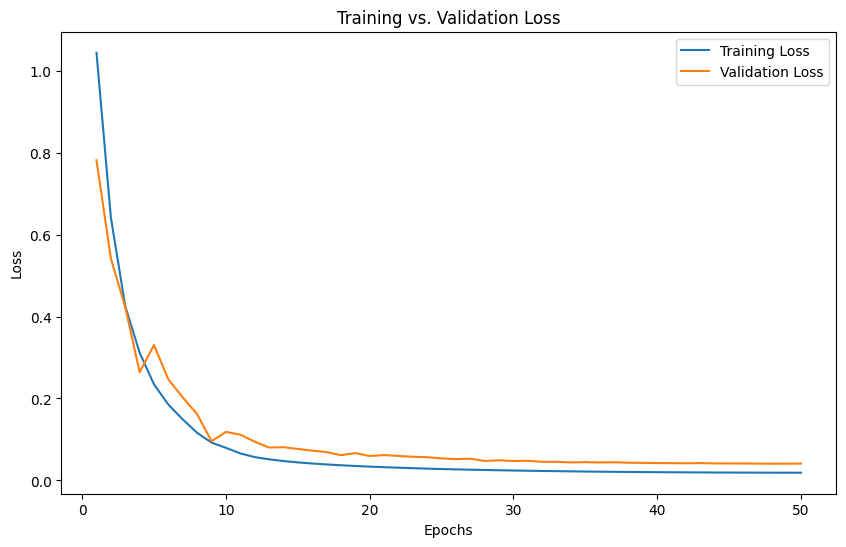

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_losses(training_losses, validation_losses):
    epochs = range(1, len(training_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_losses, label="Training Loss")
    plt.plot(epochs, validation_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs. Validation Loss")
    plt.legend()
    plt.show()


plot_losses(loss_callback.training_losses, loss_callback.validation_losses)

test_dataset = CustomImageDataset(image_dir=val_data_dir, label_dir=labels_val, transform=transform)



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
import torch
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate_model_performance(model_path, image_dir, label_dir, transform, class_mapping, batch_size=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224-in21k',
        num_labels=len(class_mapping)
    )
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()


    test_dataset = CustomImageDataset(image_dir=image_dir, label_dir=label_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    all_labels = []
    all_predictions = []


    with torch.no_grad():
        for batch in test_loader:
            inputs = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs.logits, dim=1)


            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())


    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average="weighted")
    recall = recall_score(all_labels, all_predictions, average="weighted")



    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")



    return  all_labels, all_predictions



model_path = '/content/best_model.pth'
class_mapping = CLASS_MAPPING
true_labels, predicted_labels = evaluate_model_performance(
    model_path=model_path,
    image_dir=val_data_dir,
    label_dir=labels_val,
    transform=transform,
    class_mapping=class_mapping
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-574b72d124d4>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glob

Accuracy: 98.08%
Precision: 98.18%
Recall: 98.08%


<ipython-input-24-35adbbb6fe57>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  losses = torch.load(loss_file_path)


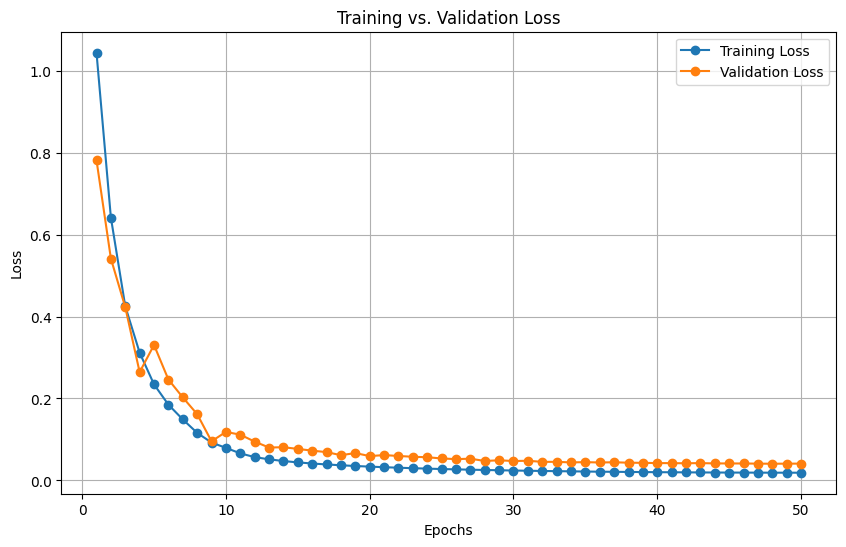

In [ ]:
import matplotlib.pyplot as plt
import torch


def plot_losses_from_file(loss_file_path):

    losses = torch.load(loss_file_path)
    training_losses = losses.get('training_losses', [])
    validation_losses = losses.get('validation_losses', [])

    if not training_losses or not validation_losses:
        print("Loss data is incomplete or not found in the file.")
        return


    epochs = range(1, len(training_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_losses, label="Training Loss", marker="o")
    plt.plot(epochs, validation_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs. Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


loss_file_path = './losses.pt'
plot_losses_from_file(loss_file_path)


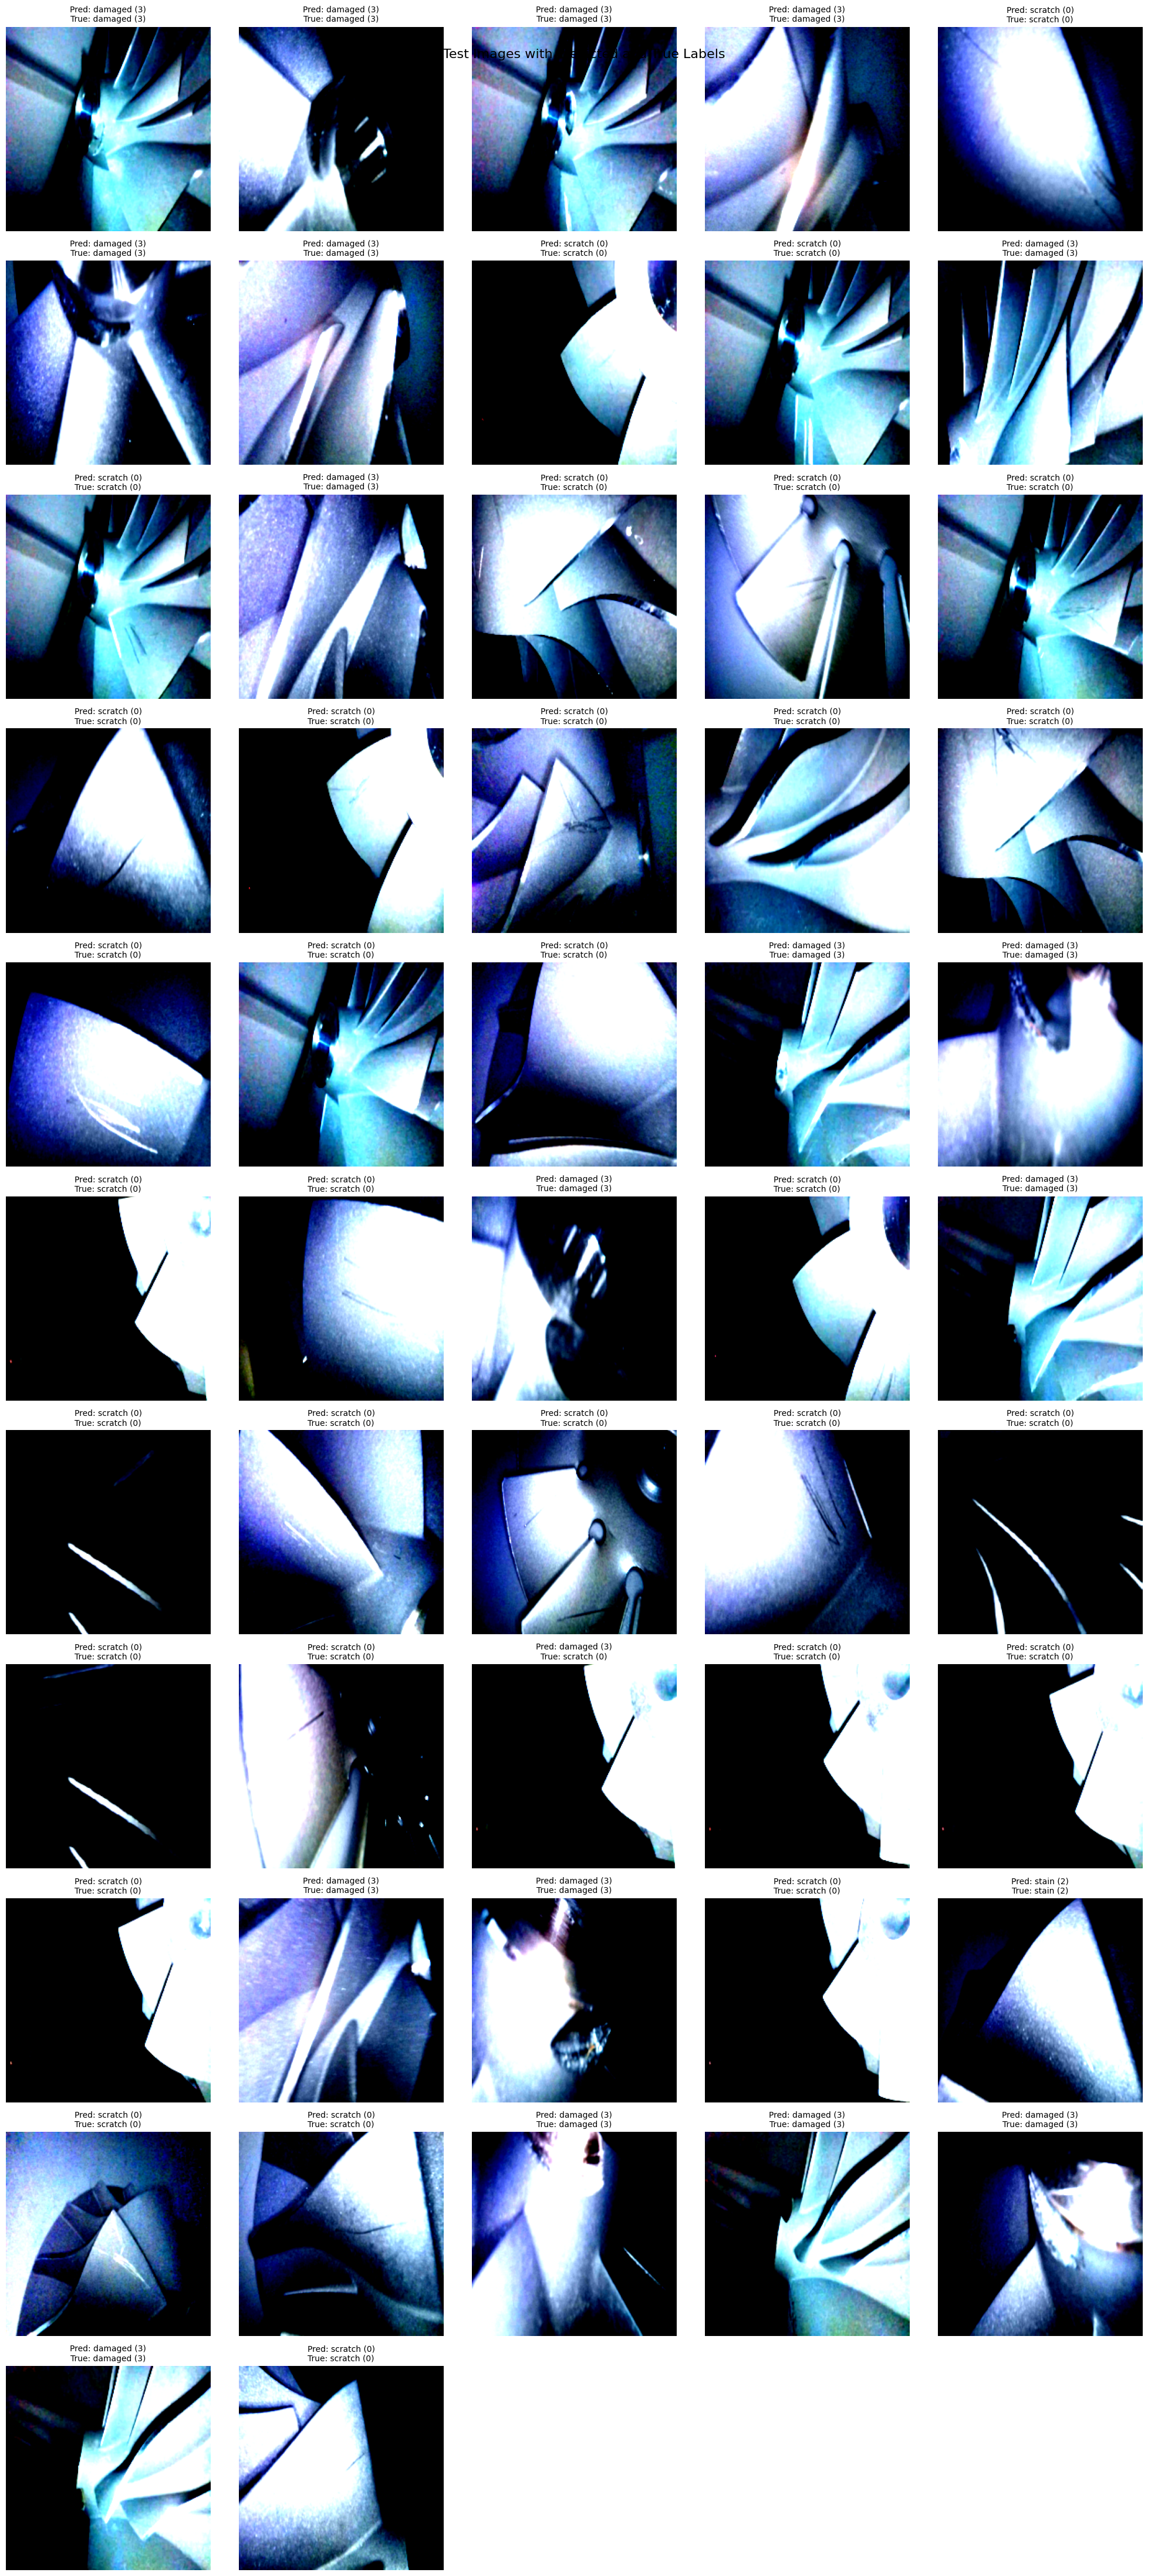

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math


def plot_all_images(test_dataset, predictions):
    num_images = len(test_dataset)
    cols = 5
    rows = math.ceil(num_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.ravel()
    for idx, ax in enumerate(axes):
        if idx < num_images:
            image, label = test_dataset[idx]["pixel_values"], test_dataset[idx]["labels"]
            image = image.permute(1, 2, 0).numpy()


            if image.dtype in ['float32', 'float64']:
                image = np.clip(image, 0, 1)
            elif image.dtype == 'int':
                image = np.clip(image, 0, 255)

            predicted_label = predictions[idx]

            pred_text = CLASS_MAPPING.get(predicted_label, f"{'scratch' if predicted_label == 0 else 'dirty' if predicted_label == 1 else 'stain' if predicted_label == 2 else 'damaged' if predicted_label == 3 else 'Unknown'} ({predicted_label})")
            true_text = CLASS_MAPPING.get(label, f"{'scratch' if label == 0 else 'dirty' if label == 1 else 'stain' if label == 2 else 'damaged' if label == 3 else 'Unknown'} ({label})")

            ax.imshow(image)
            ax.set_title(f"Pred: {pred_text}\nTrue: {true_text}", fontsize=10)
            ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.suptitle("All Test Images with Predicted and True Labels", fontsize=16)
    plt.show()


test_dataset = CustomImageDataset(image_dir=val_data_dir, label_dir=labels_val, transform=transform)
plot_all_images(test_dataset, predicted_labels)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-8-cafe72c5e6ba>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globa

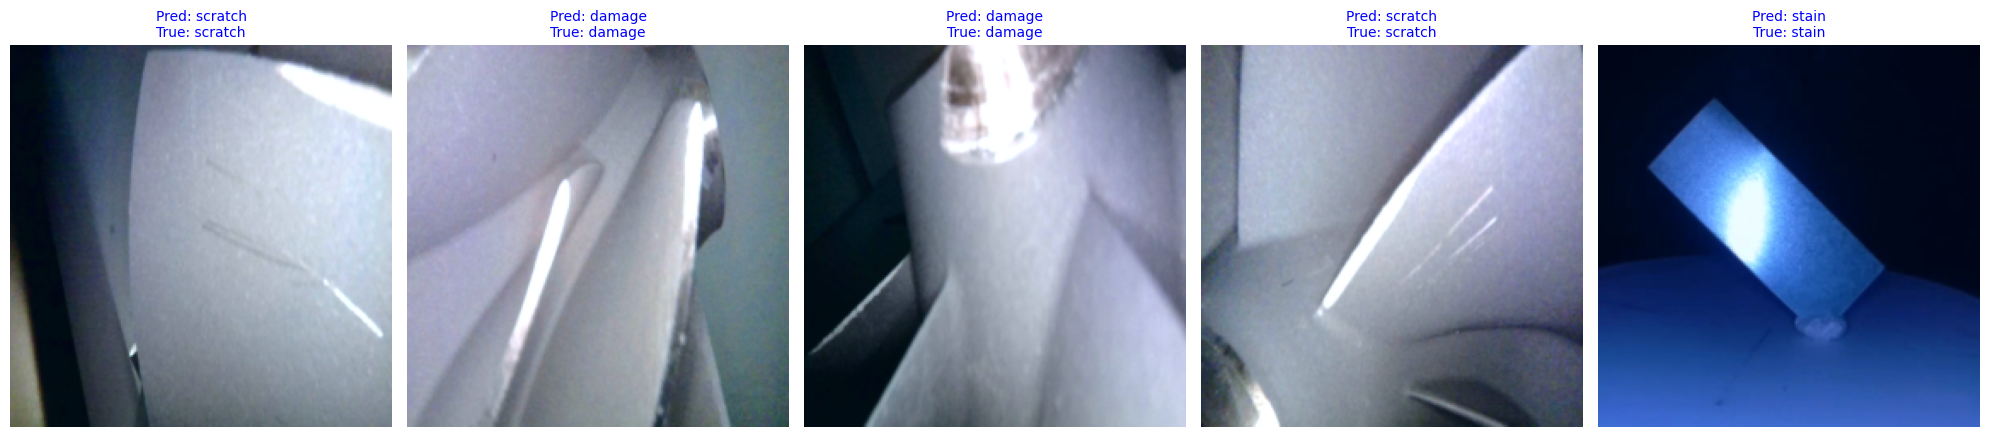

In [ ]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


CLASS_MAPPING = {0: 'scratch', 1: 'dirty', 2: 'stain', 3: 'damage'}


model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(CLASS_MAPPING)
)
model.load_state_dict(torch.load('/content/best_model.pth', map_location=torch.device('cpu')))
model.eval()


class TestImageDataset:
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        label_file = os.path.join(self.label_dir, self.image_files[idx].replace('.jpg', '.txt'))


        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        with open(label_file, 'r') as f:
            true_label = int(f.readline().split()[0])

        return {
            "image_path": image_path,
            "image": image,
            "true_label": true_label,
        }


def plot_predictions_with_labels(test_dataset, num_images=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    random_indices = random.sample(range(len(test_dataset)), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

    for idx, ax in zip(random_indices, axes):
        sample = test_dataset[idx]
        image, true_label, image_path = sample["image"], sample["true_label"], sample["image_path"]

        image_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(image_tensor)
            predicted_class = torch.argmax(outputs.logits, dim=1).item()

        predicted_label = CLASS_MAPPING[predicted_class]
        true_label_text = CLASS_MAPPING[true_label]


        image_np = image.permute(1, 2, 0).cpu().numpy()
        image_np = np.clip(image_np * 0.229 + 0.485, 0, 1)

        ax.imshow(image_np)
        ax.set_title(f"Pred: {predicted_label}\nTrue: {true_label_text}", fontsize=10, color='blue')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


test_dataset = TestImageDataset(image_dir=eval_data_dir, label_dir=labels_eval, transform=transform)


plot_predictions_with_labels(test_dataset, num_images=5)
